<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/CorEx_Amazon_preprocessed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


##All Imports go here but first, installations

In [1]:
!pip install corextopic
!pip install joblib
!pip install pyLDAvis

In [2]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd

import string

from corextopic import corextopic as ct
from corextopic import vis_topic as vt 
from sklearn.feature_extraction.text import CountVectorizer



pd.set_option('display.max_colwidth', -1)  # to view entire text in any column
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import gzip
from pprint import pprint

from bs4 import BeautifulSoup
import nltk
from nltk import FreqDist
nltk.download('stopwords') 
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer  # alternative lemmatizer
# lemma = WordNetLemmatizer()

import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim   # for visualizing found topics

import os


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Reading the data

In [3]:
df = pd.read_csv('/gdrive/My Drive/Amazon_data/lawn_processed.csv')
df.head()
df.shape

(99941, 6)

In [0]:
df['review_lemmatized'] = df['review_lemmatized'].astype(str)

##Building Dictionary,Term-Doc Matrix

In [4]:
#Amazon Review Data
# number of asins, number of associated reviews for each rating
review_cnts = df.groupby('overall').agg({'review_lemmatized':'count'}).sort_values(by = 'review_lemmatized', ascending = False)
review_cnts = review_cnts.reset_index()
review_cnts = review_cnts.rename({'review_lemmatized':'reviewCnt'}, axis = 'columns')
print('Top 10 most reviewed:\n', review_cnts.head(10),'\n')
print(review_cnts.reviewCnt.describe())
plt.figure(figsize=(8,10))


Top 10 most reviewed:
    overall  reviewCnt
0  5.0      57019    
1  4.0      18352    
2  1.0      11305    
3  3.0      7741     
4  2.0      5524      

count    5.000000    
mean     19988.200000
std      21263.597125
min      5524.000000 
25%      7741.000000 
50%      11305.000000
75%      18352.000000
max      57019.000000
Name: reviewCnt, dtype: float64


<Figure size 576x720 with 0 Axes>

<Figure size 576x720 with 0 Axes>

In [5]:
#Converting the DF to list to feed to the CorEx Model
dfToList = df['review_lemmatized'].tolist()

dfList = list(df['review_lemmatized'])

dfValues = df['review_lemmatized'].values
#print(dfList)
print(dfValues)

['gift husband . -PRON- be make -PRON- thing time love food . direction simple , easy read interpret , fun make . love different kind cuisine raichlen provide recipe everywhere along barbecue trail call -PRON- . get open page . -PRON- . love food provide -PRON- insight culture produce -PRON- . broaden horizon . yum ! !'
 'husband rarely ask anything specific , really like show . glad could find -PRON- . happy find -PRON- .'
 'guy know stuff . love seriously step step approach real food cook right . good buy second one well .'
 ...
 'recommend heater anyone . replace every year three year row . unfortunately receipt cover warranty first unit . save receipt second one 3rd one free since break within one year warranty . bad figure get use 5 month outta year ! ! also misfortune pond heater local nursery carry . -PRON- will sure home work summer get well replacement heater time one break next year put in .'
 'keep hole open ice . heavy snow clean ice up . first one 5 year replace -PRON- .'


In [6]:
# Transform Amazon Reviews data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=20000,binary = True)
doc_word = vectorizer.fit_transform(df['review_lemmatized'].values.astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(99941, 20000)

In [0]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [8]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(99941, 19437)

##Training the CorEx Topic Model

In [0]:
# Train the CorEx topic model with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [10]:
# Print a single topic from CorEx topic model. This model is trained on the Amazon Garden and Lawn Products
topic_model.get_topics(topic=7, n_words=10)

[('cut', 0.08681133901812729),
 ('blade', 0.05943530996835716),
 ('sharp', 0.04606920651805803),
 ('handle', 0.04452866637094754),
 ('axe', 0.038133798028409854),
 ('fiskar', 0.03662265178878793),
 ('branch', 0.03491889673276145),
 ('split', 0.031131921710946593),
 ('tool', 0.030751476273563057),
 ('wood', 0.02777463463125172)]

In [11]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: make,use,like,small,need,way,little,bit,want,long
1: grill,cook,weber,charcoal,cooking,heat,chicken,meat,smoker,steak
2: trap,catch,mouse,kill,mosquito,bug,fly,bait,cat,night
3: mower,grass,mow,lawn,power,gas,cord,electric,trim,blower
4: pron,thing,try,day,think,say,know,really,let,lot
5: time,problem,start,run,review,unit,hour,turn,leave,minute
6: come,water,feeder,customer,plastic,send,instruction,read,box,return
7: cut,blade,sharp,handle,axe,fiskar,branch,split,tool,wood
8: amazon,year,buy,new,store,purchase,local,cost,home,replace
9: cover,place,hold,hose,fit,hole,inside,attach,sit,outside


In [12]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(17307, 0.05617776013102268),
 (13011, 0.03852661525392694),
 (16127, 0.037825596903446994),
 (14483, 0.03693886483857519),
 (14193, 0.035386546632041764),
 (18080, 0.03368303067259606),
 (8258, 0.029472072479397395),
 (17818, 0.02792415449430446),
 (9638, 0.02778208988836475),
 (10642, 0.026591310982534973)]

In [13]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[8 5 3 ... 4 3 6]
(19437,)


In [14]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=7, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(17675, 0.0),
 (27880, 0.0),
 (72135, 0.0),
 (27876, 0.0),
 (25664, 0.0),
 (28510, 0.0),
 (1140, 0.0),
 (27875, 0.0),
 (27872, 0.0),
 (9016, 0.0)]

In [15]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(99941, 10)


In [16]:
print(topic_model.labels.shape) # n_docs x k_topics

(99941, 10)


##Total Corelation and Model Selection

In [17]:
#Here trying to implement what the paper proposes. Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.
topic_model.tc 

8.888952179668108

In [18]:
topic_model.tcs.shape # k_topics

(10,)

In [19]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

8.888952179668108
8.888952179668108


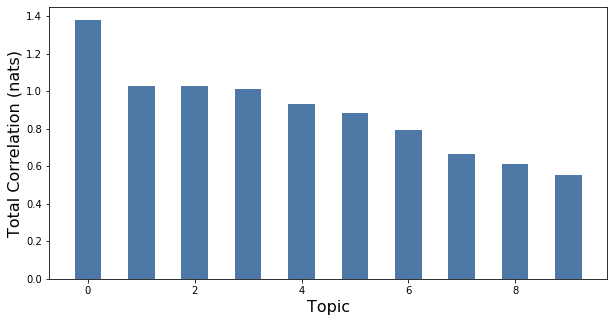

In [20]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('Distribution of TCs for each topic', dpi=600)

##Pointwise Document TC

In [21]:
topic_model.log_z.shape # n_docs x k_topics

(99941, 10)

In [22]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[1.38017317 1.02648705 1.02618352 1.01171852 0.9342494  0.88593937
 0.7935054  0.66537163 0.60955051 0.55577361]
[1.38017317 1.02648705 1.02618352 1.01171852 0.9342494  0.88593937
 0.7935054  0.66537163 0.60955051 0.55577361]


##Now adding some hierarchy to the Topic Model

In [23]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

In [0]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')


##Introducing Anchoring in the semi-supervised topic model

In [0]:
# Anchor one word to the eighth topic
anchor_words = ['purchase']

In [0]:
# Anchor the word 'shipping' to the seventh topic
anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [30]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=9))
print('8: ' + ','.join(topic_words))

8: sound,hear,true,buck,extra,complain,folk,person,temper,speak


In [0]:
# Anchor 'electric' and 'electronic' to first topic, 'birds' and 'garden' to second topic, so on...
anchor_words = [['use', 'efficient'], ['shipping', 'delivery'], ['money', 'worth'], ['price', 'quality']]

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [32]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: use,efficient,extensively,conjunction,exclusively,seldom,sparingly,ordinarily,trickier,preclude
1: shipping,delivery,amazon,customer,service,send,order,free,ship,receive
2: money,worth,waste,save,penny,investment,pricey,spent,aggravation,wast
3: price,quality,reasonable,beat,reasonably,excellent,value,fair,tag,bargain


In [0]:
# Anchor with single words and groups of words
anchor_words = ['job', ['job', 'use'], ['job', 'delivery'], 'shopping']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [34]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: job,drifted,reassurance,pressurewasherparts,untethered,crisscross,contemplated,cmm,boogle,battleship
1: use,job,extensively,conjunction,seldom,sparingly,workhorse,silently,trickier,sporadic
2: job,delivery,deservedly,swerve,hazzle,thee,willed,chamomile,rd,trustworthy
3: shopping,point,note,experience,mean,reviewer,update,level,simply,research


In [0]:
vt.vis_rep(topic_model, column_label=words, prefix='./twenty')

In [0]:
%pwd
%cd /content/
%pwd

/content


'/content'

In [0]:
#Saving the CorEx topics generated in a file
import sys
import csv
with open("corex_topic.txt","w+") as file:
     for n in range(len(anchor_words)):
         topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
         #print('{}: '.format(n) + ','.join(topic_words))
         file.write('{}: '.format(n) + ','.join(topic_words)+'\n')